In [1]:
import os
from os import walk
from os import path
import tensorflow as tf
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import scipy as scp
from math import erf
import yfinance as yf
import collections
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
from datetime import date
#from stocktrends import Renko
from itertools import cycle, islice
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
import mplfinance as mpf
import copy

C:\Users\salmasi\.conda\envs\tensorflow2\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
def plot(data,lim1=-2,lim2=-1,means=(1),name="stock",frmaesize=(10,6),show_nonetrading=True,show_volume=True):
    daily=data[lim1:lim2]
    daily.index.name = 'Date'
    daily.shape
    mpf.plot(daily,type='candle',mav=means,volume=show_volume,show_nontrading=show_nonetrading,figsize=frmaesize,title=name)   

In [3]:
f = []
for (dirpath, dirnames, filenames) in walk("data\\"):
    f.extend(filenames)
    break
tickers= [x.replace('.csv', '') for x in filenames]

In [4]:
'''read data from csv file'''
dfs={}
for ticker in tickers:
    try:
        path.exists("data\\"+ticker+".csv")
        dfs[ticker]=pd.read_csv("data\\"+ticker+".csv",index_col=0,parse_dates=True)
        ### dfs[ticker]["ticker"]=ticker
        ### dfs[ticker]["Date"]=dfs[ticker].index
    except OSError as e:
        print("Error: %s : %s" % ("data\\"+ticker+".csv", e.strerror))

    ### dfs[ticker].rename(columns={'Adj Close':'Adj_Close'}, inplace=True)
    ### dfs[ticker].rename(columns=str.lower, inplace=True)
    ### dfs[ticker]['intiger_index']=np.arange(1,len(dfs[ticker])+1)
    ### dfs[ticker]['timestamp_index']=dfs[ticker].index



# Plot

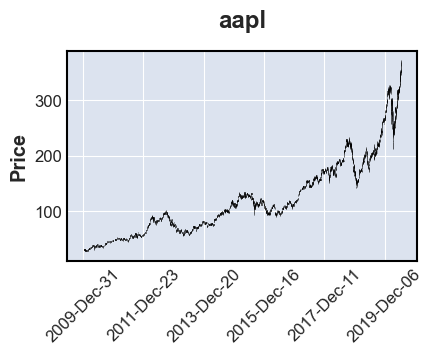

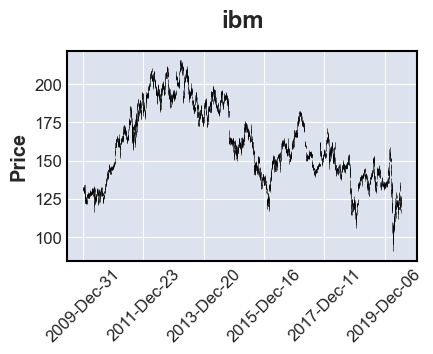

In [5]:
lim1=0
lim2=-1
means=()
for ticker in tickers:
    data = pd.read_csv("data\\"+ticker+".csv",index_col=0,parse_dates=True)
    plot(data,lim1,lim2,means,ticker,frmaesize=(5,3),show_nonetrading=False,show_volume=False)
## data = pd.read_csv("alldata.csv",index_col=0,parse_dates=True)
## plot(data,-1*len(data),lim2,(),name="alldata",frmaesize=(10,6),show_nonetrading=False,show_volume=False)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


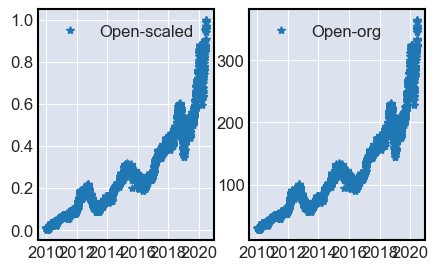

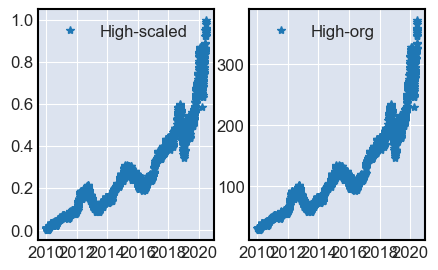

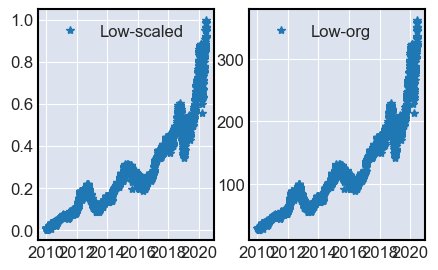

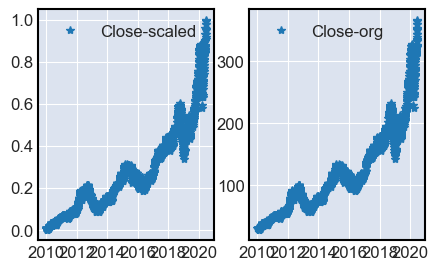

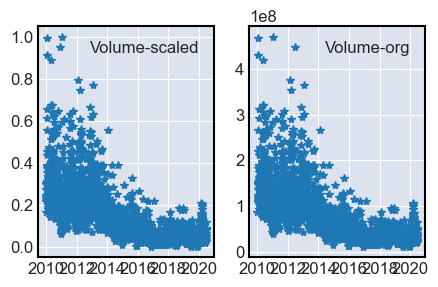

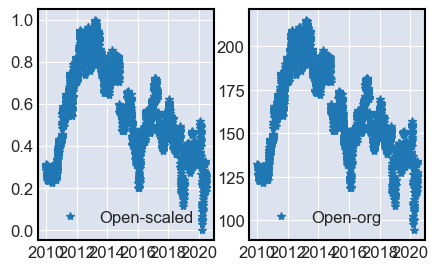

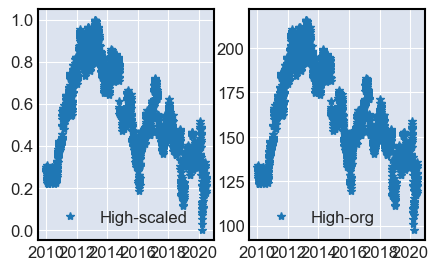

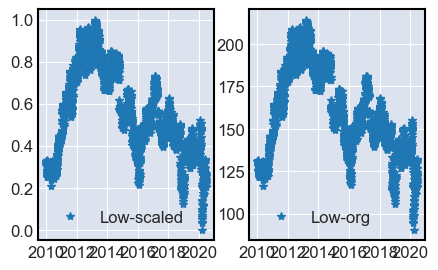

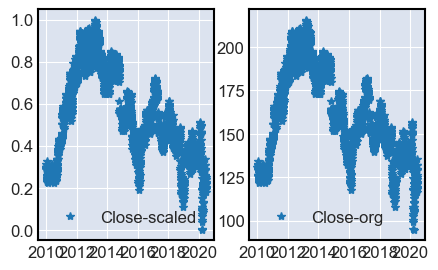

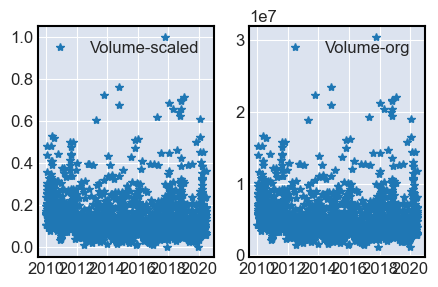

In [6]:
'''scale values'''
scaler = MinMaxScaler()
dfs_scaled={}
target={}
dfs_cp = copy.deepcopy(dfs)
for ticker in tickers:
    target[ticker]= dfs_cp[ticker].pop('Adj Close')
    print(dfs[ticker].keys())
    print(dfs_cp[ticker].keys())

    dfs_scaled_mat=scaler.fit_transform(dfs_cp[ticker].values)
    dfs_scaled[ticker] = pd.DataFrame(dfs_scaled_mat, index=dfs_cp[ticker].index, columns=dfs_cp[ticker].columns)

    for key in dfs_scaled[ticker].keys():
        fig, ax = plt.subplots(1,2, figsize = (5,3))        
        ax[0].plot(dfs_scaled[ticker][key],'*', label = key + '-scaled')
        ax[1].plot(dfs_cp[ticker][key],'*', label = key+'-org')

        ax[0].legend()
        ax[1].legend()

In [38]:
def split_data(df,targ,p_train,p_dev):
    dataset = tf.data.Dataset.from_tensor_slices((df.values, targ.values))
    len_set=len(df)
    len_train=int(np.floor(len_set*p_train))
    len_dev=int(np.floor(len_set*p_dev))
    len_test=int(len_set-p_dev-p_train)
    train= dataset.take(len_train)
    rem1= dataset.skip(len_train)
    dev= rem1.take(len_dev)
    rem2 = rem1.skip(len_dev)
    test = rem2.take(-1)
    return train,dev,test,len_train,len_dev,len_test

In [40]:
'''slice trainsets'''
train_sets={}
dev_sets={}
test_sets={}


train,dev,test,ltrain,ldev,ltest =split_data(dfs_scaled['aapl'],target['aapl'],0.9,0.05)
train_shuffle= train.shuffle(ltrain).batch(1024)
dev_shuffle= dev.shuffle(ldev).batch(16)
dev_test= dev.shuffle(ltest).batch(16)



In [41]:
def get_compiled_model(input_size):
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(input_size, activation='relu'),
    tf.keras.layers.Dense(input_size, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [43]:
for elements,_ in train_shuffle.take(1):  # only take first element of dataset
    numpy_elements = elements.numpy()
    input_size = (numpy_elements.size)
model = get_compiled_model(input_size)

In [44]:
fit= model.fit(train_shuffle, epochs=2)

Epoch 1/2

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

3/3 [==============================] - 1s 332ms/step - loss: -70.6871 - accuracy: 0.0000e+00
Epoch 2/2
3/3 [==============================] - 1s 346ms/step - loss: -550.6164 - accuracy: 0.0000e+00


(array([[19.695982],
       [19.920538],
       [18.834984],
       [25.15828 ],
       [19.610313],
       [19.843025],
       [21.679724],
       [20.21443 ],
       [19.157768],
       [20.352722],
       [21.041569],
       [19.888704],
       [21.359324],
       [26.20521 ],
       [24.360691],
       [20.509048],
       [23.288397],
       [22.764704],
       [21.01334 ],
       [25.74591 ],
       [21.136263],
       [20.491194],
       [23.40868 ],
       [20.148466],
       [20.001707],
       [20.41036 ],
       [22.650038],
       [24.977297],
       [21.3235  ],
       [19.531807],
       [19.505116],
       [21.511162],
       [20.4824  ],
       [25.727406],
       [25.400635],
       [22.638151],
       [24.86181 ],
       [21.752254],
       [19.567974],
       [24.945852],
       [21.934376],
       [20.076143],
       [19.537455],
       [23.05444 ],
       [19.616833],
       [21.1189  ],
       [21.824707],
       [20.79989 ],
       [19.551022],
       [20.271648],

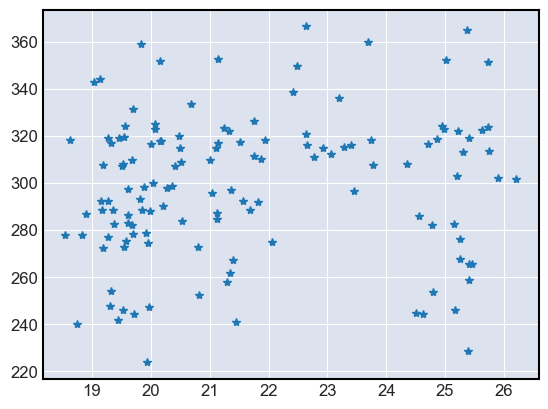

In [60]:
predictions = model.predict(dev_shuffle)
plt.plot(predictions,target['aapl'][-ldev:],'*')
print((predictions,target['aapl'][-ldev:],'*'))

In [ ]:
# holdDays = 5
# totalDays = dfs_concat_scaled_dataframe.shape[0]
# #mlpr.fit(dfs_concat_scaled_dataframe.index[0:(totalDays-holdDays)].T, dfs_concat_scaled_dataframe['Adj Close'][0:(totalDays-holdDays)])
# mlpr.fit(a, dfs_concat_scaled_dataframe['Adj Close'][0:(totalDays-holdDays)])

In [ ]:
# #Predict the stock price using the model
# pricePredict = mlpr.predict(date_idx)
# #Display the predicted reuslts agains the actual data
# plt.plot(date_idx, adj_close_price)
# plt.plot(date_idx, pricePredict, c='#5aa9ab')
# plt.show()

In [ ]:
# #Number of neurons in the input, output, and hidden layers
# input2 = 1
# output2 = 1
# hidden2 = 50
# #array of layers, 3 hidden and 1 output, along with the tanh activation function 
# layers = [('F', hidden2), ('AF', 'tanh'), ('F', hidden2), ('AF', 'tanh'), ('F', hidden2), ('AF', 'tanh'), ('F', output2)]
# #construct the model and dictate params
# mlpr2 = ANNR([input2], layers, batchSize = 256, maxIter = 10000, tol = 0.01, reg = 1e-4, verbose = True)

In [ ]:
# holdDays = 5
# totalDays = len(date_idx)
# mlpr2.fit(date_idx[0:(totalDays-holdDays)], adj_close_price[0:(totalDays-holdDays)])
# pricePredict2 = mlpr2.predict(date_idx)

In [ ]:
# plt.plot(date_idx, adj_close_price)
# plt.plot(date_idx, pricePredict, c='#5aa9ab')
# plt.plot(date_idx, pricePredict2, c='#8B008B')
# plt.show()

In [ ]:
# pricePredict3 = mlpr2.predict(date_idx[-holdDays:])
# print((pricePredict3-date_idx[-holdDays:])/date_idx[-holdDays:]*100)